In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import shap
from xgboost import XGBClassifier, XGBRegressor

# Display options for Pandas
pd.set_option('display.max_columns', None)

# Load the dataset; adjust the path if your file is elsewhere
df = pd.read_csv('data/heart.csv')

# Basic info
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (918, 12)
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


/home/azureuser/5106-project2/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of duplicate rows: 0
Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.00

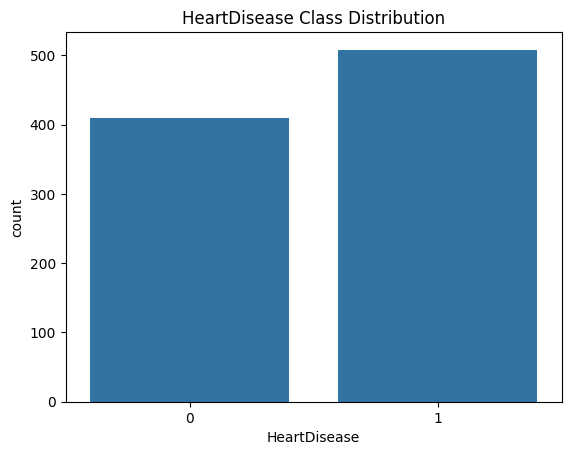

In [2]:
# Check duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicates if any
df = df.drop_duplicates().reset_index(drop=True)

# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

# Summary statistics for numeric columns
print(df.describe())

# Distribution of target variable
target_counts = df['HeartDisease'].value_counts()
print("Class distribution:\n", target_counts)

# Visualize target distribution
sns.countplot(x='HeartDisease', data=df)
plt.title('HeartDisease Class Distribution')
plt.show()


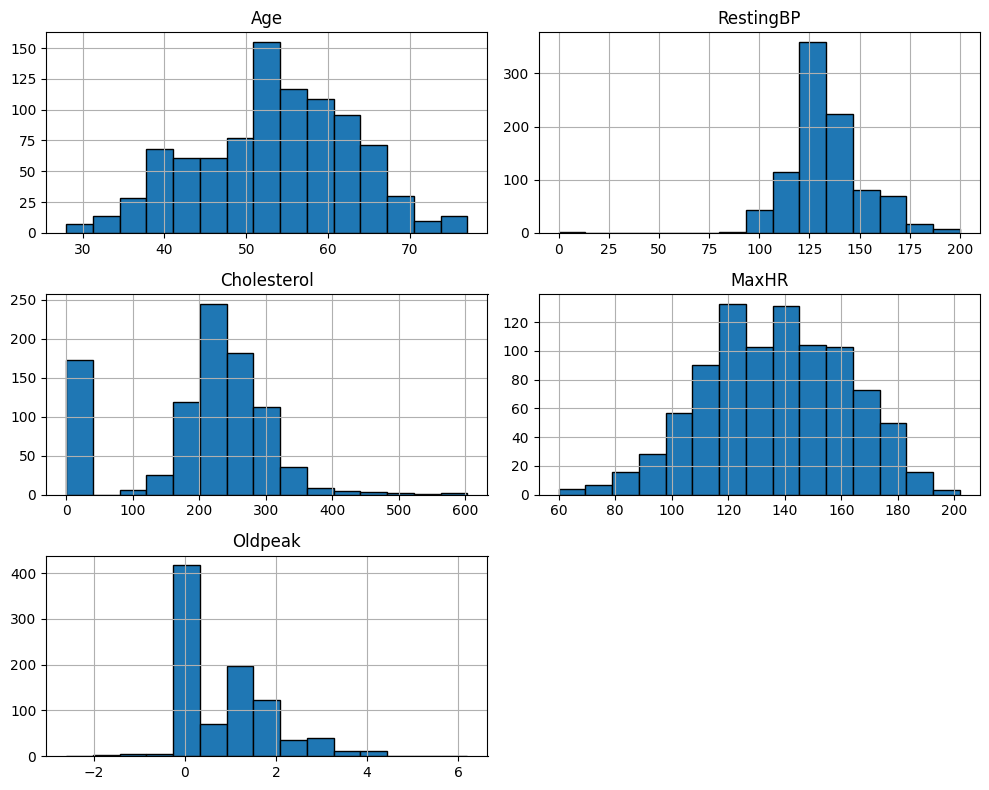

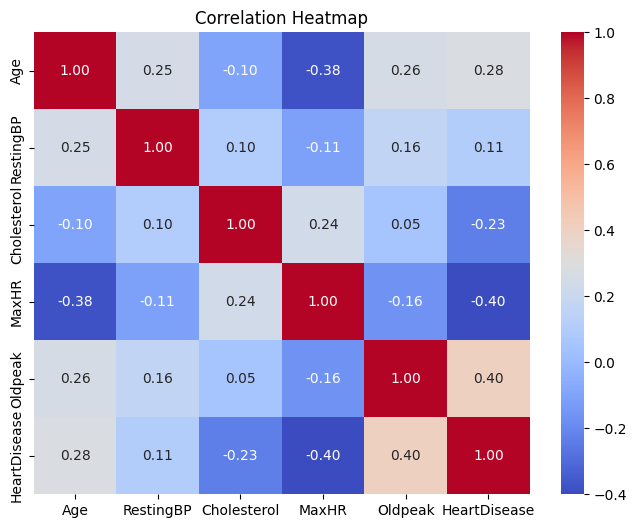

In [3]:
# Histograms for numeric variables
numeric_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
df[numeric_cols].hist(bins=15, figsize=(10,8), edgecolor='black')
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
corr_matrix = df[numeric_cols + ['HeartDisease']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [4]:
# Identify categorical and numeric columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak','FastingBS']

# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Preprocess: OneHotEncode categorical, scale numeric
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split into train+validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (550, 11)
Validation set size: (184, 11)
Test set size: (184, 11)


In [5]:
def custom_eval_loss(y_true, y_pred_labels, false_negative_cost=5, false_positive_cost=1):
    """
    Compute custom evaluation loss given true labels and predicted labels.
    False negatives and false positives are penalised differently.
    """
    y_true = np.array(y_true)
    y_pred_labels = np.array(y_pred_labels)
    
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()
    
    loss = (false_negative_cost * fn) + (false_positive_cost * fp)
    return loss


In [6]:
# Pipeline: preprocess then logistic regression with logistic loss
model_log_loss = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log_loss',  # logistic loss
        penalty='l2',
        max_iter=1000,
        tol=1e-3,
        random_state=42))
])

# Fit model
model_log_loss.fit(X_train, y_train)

# Predict probabilities on validation set
y_val_proba_log = model_log_loss.predict_proba(X_val)[:, 1]

# Compute validation AUC
auc_log = roc_auc_score(y_val, y_val_proba_log)
print(f"Validation AUC (Logistic Regression with logistic loss): {auc_log:.4f}")


Validation AUC (Logistic Regression with logistic loss): 0.8926


In [7]:
# Pipeline: preprocess then linear model with squared error
model_squared = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='squared_error',  # L2 loss
        penalty='l2',
        max_iter=1000,
        tol=1e-3,
        random_state=42))
])

# Fit model
model_squared.fit(X_train, y_train)

# Predict continuous output and convert to probabilities via sigmoid-like scaling
y_val_pred_squared = model_squared.decision_function(X_val)
# Scale to 0-1; using min–max scaling to approximate probabilities
y_val_proba_squared = (y_val_pred_squared - y_val_pred_squared.min()) / (
    y_val_pred_squared.max() - y_val_pred_squared.min() + 1e-8)

# Compute validation AUC
auc_squared = roc_auc_score(y_val, y_val_proba_squared)
print(f"Validation AUC (Linear model with squared error): {auc_squared:.4f}")


Validation AUC (Linear model with squared error): 0.3815


In [8]:
# Pipeline: preprocess then XGBoost classifier with logistic objective
model_xgb_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42))
])

# Fit model
model_xgb_log.fit(X_train, y_train)

# Predict probabilities on validation set
y_val_proba_xgb_log = model_xgb_log.predict_proba(X_val)[:, 1]

# Compute validation AUC
auc_xgb_log = roc_auc_score(y_val, y_val_proba_xgb_log)
print(f"Validation AUC (XGBoost logistic): {auc_xgb_log:.4f}")


Validation AUC (XGBoost logistic): 0.9004


In [9]:
# Pipeline: preprocess then XGBoost regressor with squared error objective
model_xgb_sq = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42))
])

# Fit model
model_xgb_sq.fit(X_train, y_train)

# Predict continuous output on validation set
y_val_pred_xgb_sq = model_xgb_sq.predict(X_val)

# Scale predictions to 0-1 range for AUC calculation
y_val_proba_xgb_sq = (y_val_pred_xgb_sq - y_val_pred_xgb_sq.min()) / (
    y_val_pred_xgb_sq.max() - y_val_pred_xgb_sq.min() + 1e-8)

# Compute validation AUC
auc_xgb_sq = roc_auc_score(y_val, y_val_proba_xgb_sq)
print(f"Validation AUC (XGBoost squared error): {auc_xgb_sq:.4f}")


Validation AUC (XGBoost squared error): 0.9066


In [15]:
#  model_xgb_sq is best lets go
best_model = model_xgb_sq  


Threshold with minimum custom loss: 0.43
Cost at this threshold: 9.0


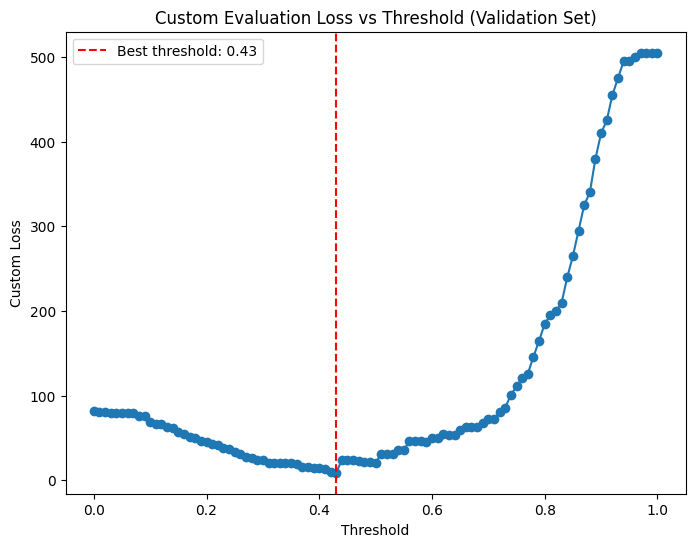

In [19]:
# Determine probability-like scores on the validation set
if hasattr(best_model.named_steps['classifier'], "predict_proba"):
    # Classifier: use predicted probabilities
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
else:
    # Regressor: use continuous predictions and scale to 0-1
    y_val_cont = best_model.predict(X_val)
    y_val_proba = (y_val_cont - y_val_cont.min()) / (y_val_cont.max() - y_val_cont.min() + 1e-8)

# Evaluate thresholds from 0 to 1
thresholds = np.linspace(0, 1, 101)
evaluation_results = []

for threshold in thresholds:
    y_pred_labels = (y_val_proba >= threshold).astype(int)
    cost = custom_eval_loss(y_val, y_pred_labels, false_negative_cost=5, false_positive_cost=1)
    evaluation_results.append({'threshold': threshold, 'cost': cost})

threshold_df = pd.DataFrame(evaluation_results)
best_threshold_row = threshold_df.loc[threshold_df['cost'].idxmin()]
best_threshold = best_threshold_row['threshold']
print("Threshold with minimum custom loss:", best_threshold)
print("Cost at this threshold:", best_threshold_row['cost'])

# Plot cost vs threshold as before
plt.figure(figsize=(8,6))
plt.plot(threshold_df['threshold'], threshold_df['cost'], marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Custom Loss')
plt.title('Custom Evaluation Loss vs Threshold (Validation Set)')
plt.legend()
plt.show()


In [20]:
# Fit the best model on full training+validation data
best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Obtain scores on the test set
if hasattr(best_model.named_steps['classifier'], "predict_proba"):
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
else:
    y_test_cont = best_model.predict(X_test)
    y_test_proba = (y_test_cont - y_test_cont.min()) / (y_test_cont.max() - y_test_cont.min() + 1e-8)

# Convert probabilities to labels using the selected threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Compute test AUC
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test AUC: {test_auc:.4f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, digits=4)

print("Confusion Matrix on Test Set:\n", conf_matrix)
print("Classification Report on Test Set:\n", report)

# Custom evaluation loss on test set
test_custom_loss = custom_eval_loss(y_test, y_test_pred, false_negative_cost=5, false_positive_cost=1)
print("Custom evaluation loss on test set:", test_custom_loss)


Test AUC: 0.9259
Confusion Matrix on Test Set:
 [[68 14]
 [ 8 94]]
Classification Report on Test Set:
               precision    recall  f1-score   support

           0     0.8947    0.8293    0.8608        82
           1     0.8704    0.9216    0.8952       102

    accuracy                         0.8804       184
   macro avg     0.8826    0.8754    0.8780       184
weighted avg     0.8812    0.8804    0.8799       184

Custom evaluation loss on test set: 54


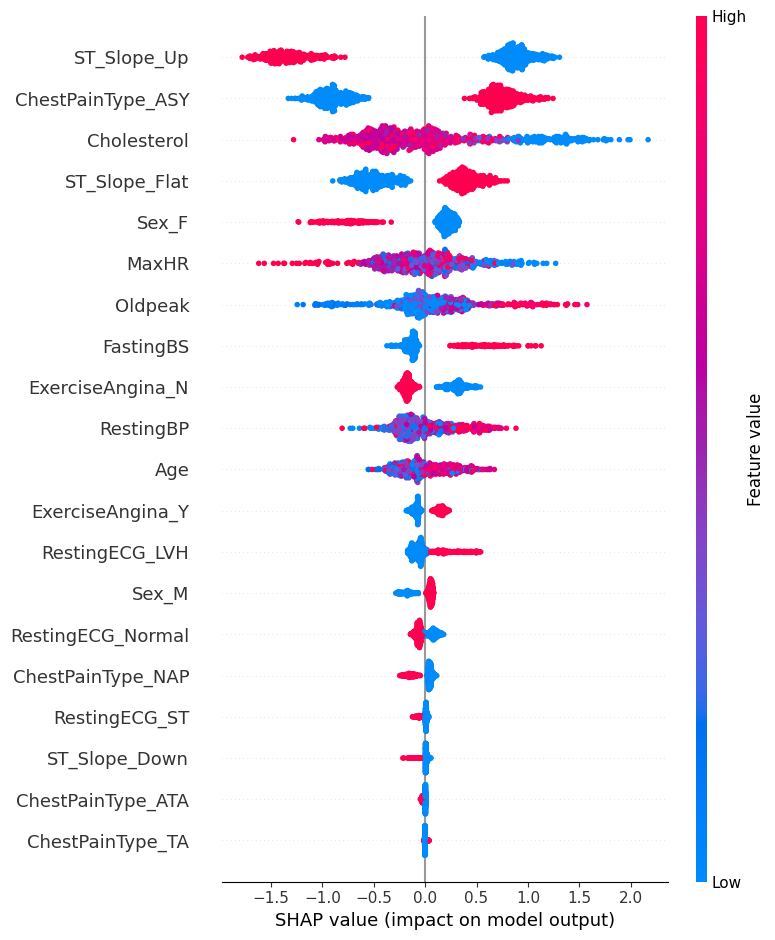

Graph: 4


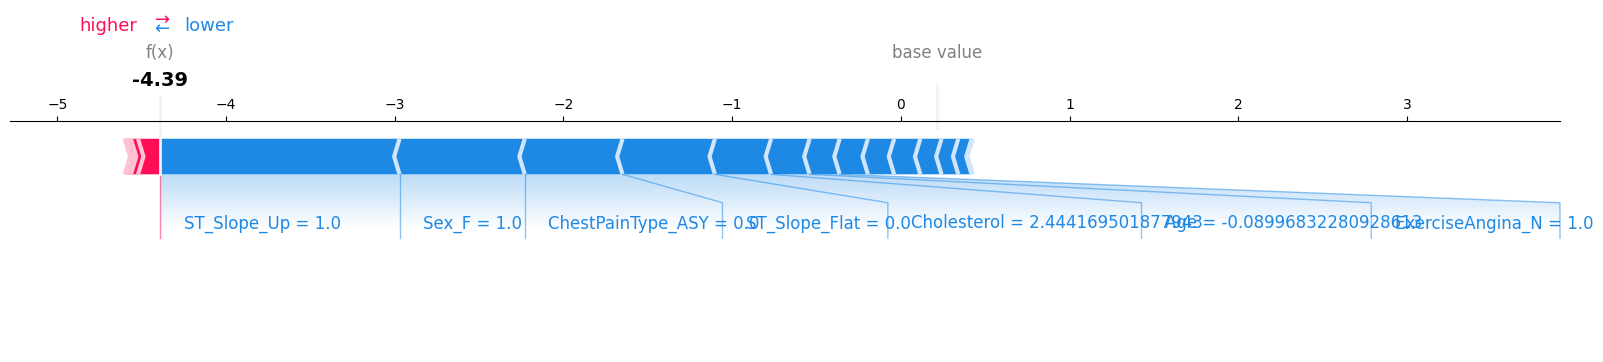

Graph: 8


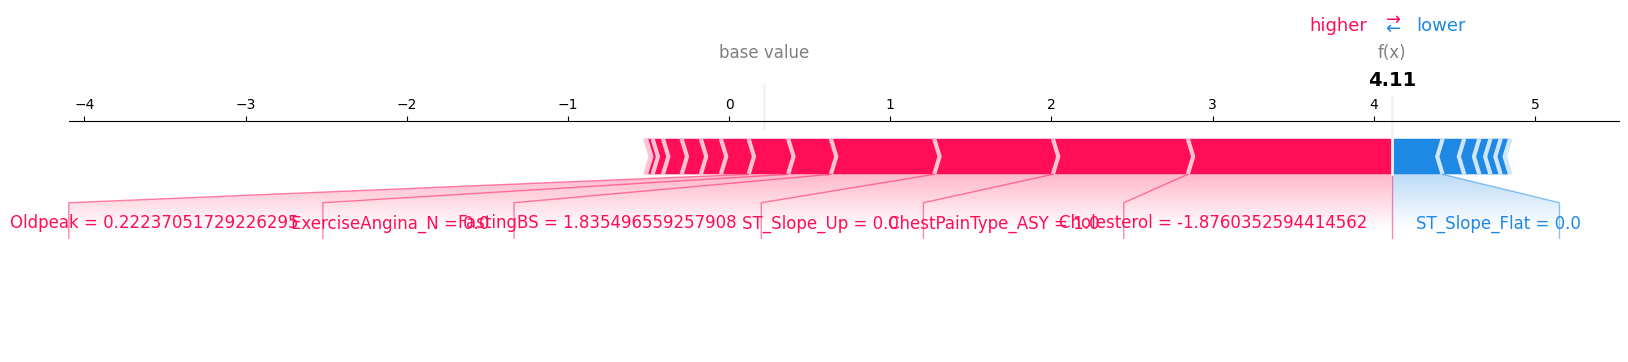

Graph: 34


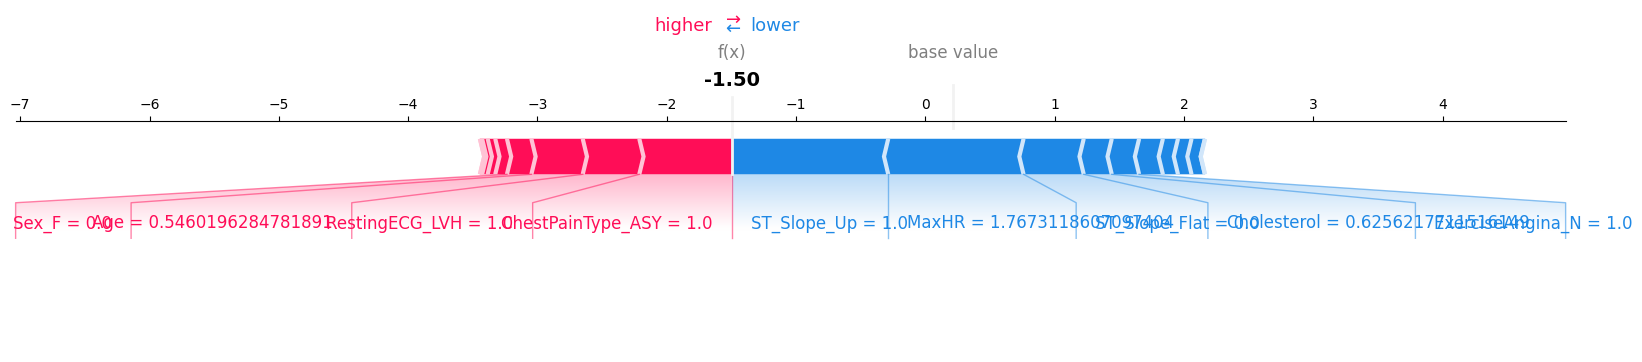

In [26]:
# Ensure we have a tree-based model for SHAP; here we use XGBoost logistic
tree_model = model_xgb_log  # Replace with the variant you trained if different

# Fit the tree-based model on the full training+validation set
tree_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Extract the processed features after preprocessing for SHAP analysis
X_train_val_processed = tree_model.named_steps['preprocessor'].transform(pd.concat([X_train, X_val]))
feature_names = (
    list(numeric_cols) + 
    list(tree_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
)

# SHAP analysis
explainer = shap.TreeExplainer(tree_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_train_val_processed)

# Global interpretation: summary plot
shap.summary_plot(shap_values, X_train_val_processed, feature_names=feature_names)

# Local interpretation: select a few examples
for i in [4, 8, 34]:  # show explanations for three cases
    print(f"Graph: {i}")
    shap.force_plot(
        explainer.expected_value, 
        shap_values[i], 
        X_train_val_processed[i], 
        feature_names=feature_names,
        matplotlib=True
    )
